# **Text-to-Image Generation using Stable Diffusion with Pre-trained LAION-5B Dataset**

##**STABLE DIFFUSION**

- A generative AI model that produces unique photorealistic images from text and image prompts.

- Stable diffusion was developed by STABILITY AI.


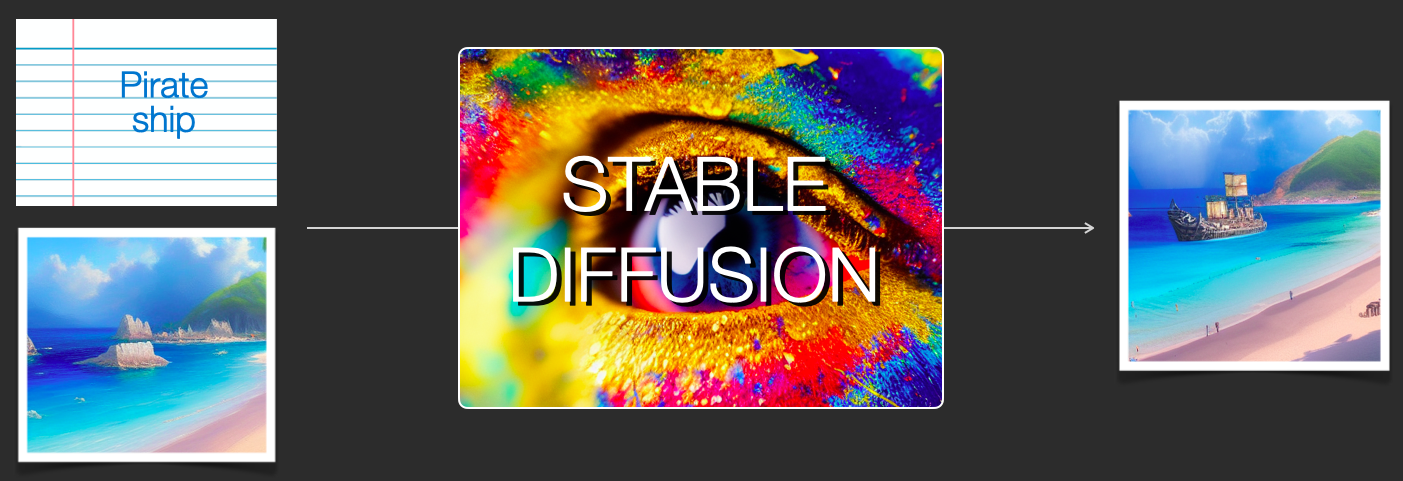


**DIFFUSION**

- Refers to transfer of something from higher concentration to lower concentration.
- Stable diffusion has 2 types of diffusion:

  1. Forward Diffusion
  2. Backward Diffusion
  

**1. Forward Diffusion**
   - Continuously adds noise to a clear image, makes it a noise image.

**2. Backward Diffusion**
   - A transformation process from a noisy image to a clear ones. As the diffusion increases, the noise generally removed and image becomes clearer. This is known as **denoising**.

**WHAT IS STABLE IN STABLE DIFFUSION?**
- In **Stable Diffusion**, "**stable**" refers to its efficient and stable training process, leveraging latent diffusion models that operate in a lower-dimensional latent space, reducing computational complexity while maintaining high-quality outputs.

**STABLE DIFFUSION ARCHITECTURE**

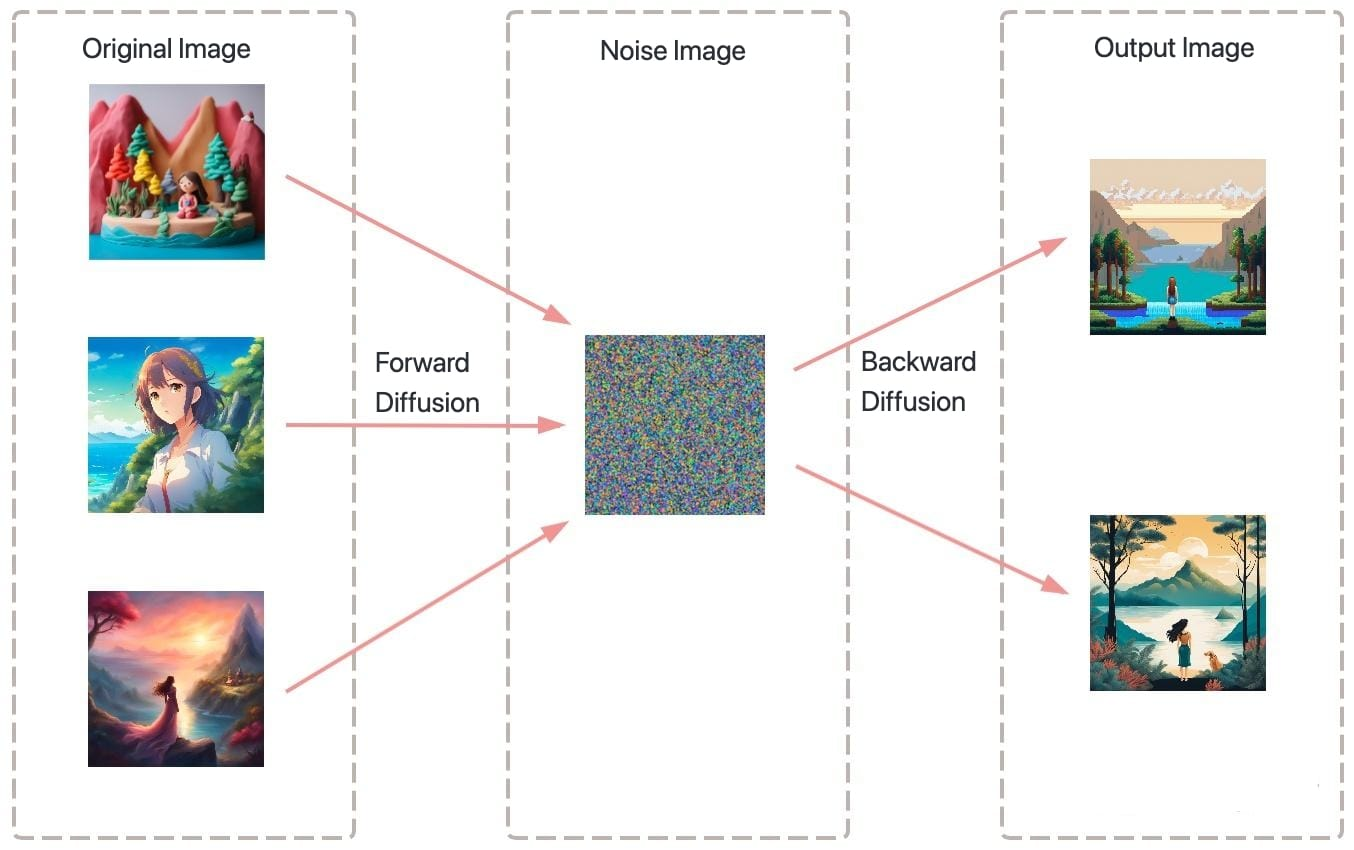

##**ARCHITECTURE OF STABLE DIFFUSION**

**1. Text Prompt:**
  - ***Input***: A natural language description provided by the user (e.g., "A serene beach at sunset").
  - ***Process***: The text is passed through a Text Encoder (e.g., CLIP or Transformer-based encoder) to generate text embeddings, which represent the prompt in a format suitable for the model.


**2. Original Image from Dataset:**
   - A real image from the training dataset (e.g., LAION-5B) that matches the textual description is paired with the prompt during training.


**3. Text Encoder:**
   - The encoder (like CLIP) converts the input text into a latent embedding, capturing semantic information about the prompt. This embedding influences the diffusion process.


**4. Encoder (Image to Latent Space):**
   - The input image (from the dataset) is passed through a pretrained Variational Autoencoder (VAE).
   - The VAE encodes the image into a latent space, a compressed representation capturing essential features.


**5. Latent Space (Diffusion Process):**
   - The diffusion model operates in the latent space rather than directly on pixels, making the process more computationally efficient.
   - ***Forward Diffusion***: Gradually adds noise to the latent representation during training, simulating a destruction process.
   - ***Reverse Diffusion***: During generation, it denoises the latent representation step-by-step, guided by the text embedding, to reconstruct the desired image.


**6. Decoder (Latent to Image):**
   - The denoised latent representation is passed through the VAE Decoder, which reconstructs the full-resolution image.


**7. Generated Image:**
   - ***Output***: A new, high-quality image aligned with the textual description provided.

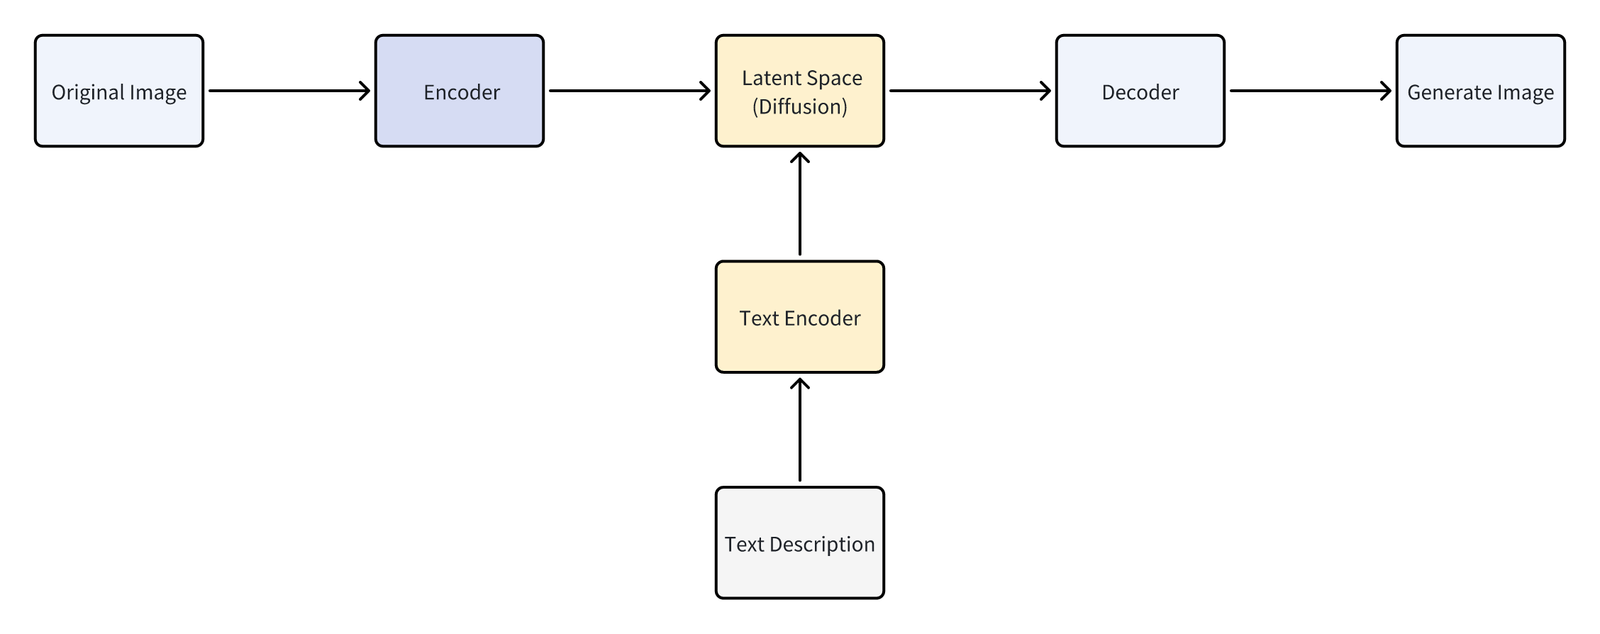

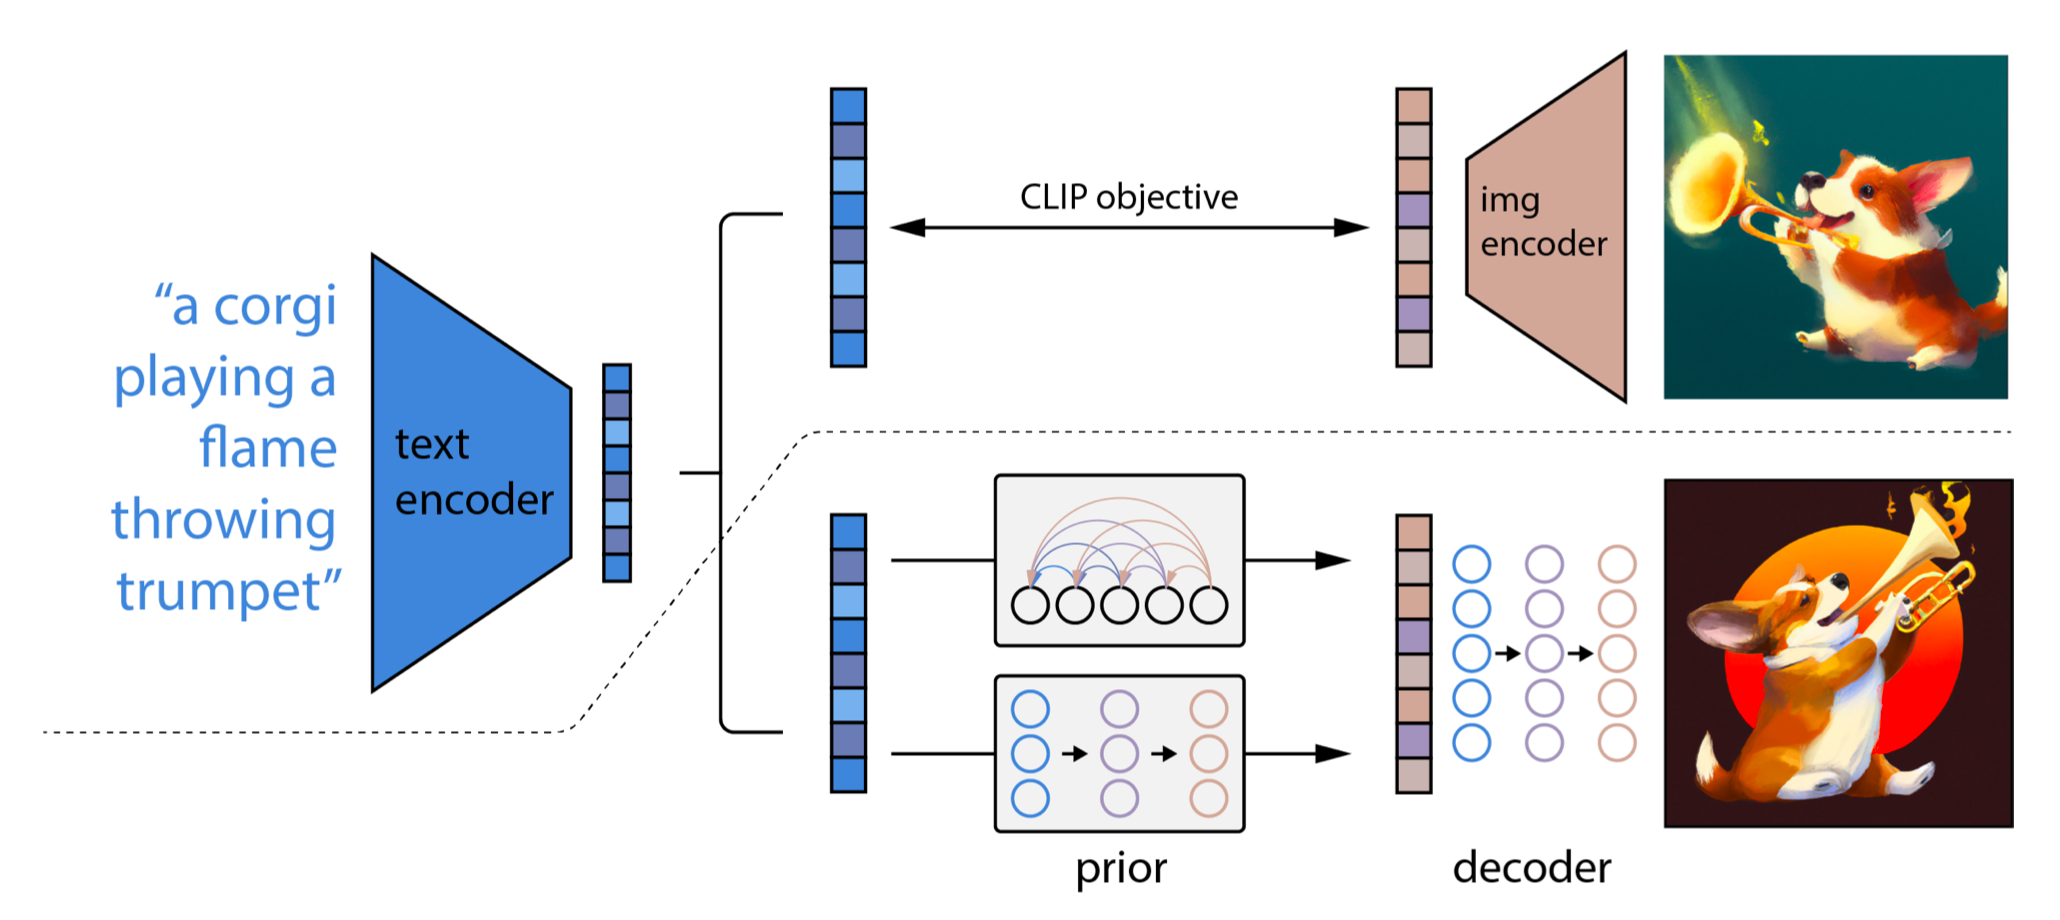

## **SAMPLE EXPLANATION CODE FOR TRAINING PROCESS**

**1. Sample Code for Loading LAION-5B Dataset**


The LAION-5B dataset is one such collection, which contains billions of image-text pairs.

**Summary:**
- Loading small subset of the dataset (1%)
- Sample entry (Printing the image URL and caption)

In [ ]:
from datasets import load_dataset

#Loading a small subset of LAION-5B dataset for demonstration
dataset = load_dataset("laion/laion5b", split="train[:1%]")

#Print a sample that contains the image URL and caption
print(dataset[0])


**2. Preprocessing of the data**

This includes,
- Resizing the images
- Tokenizing the textual data into embeddings

**Summary:**
- Importing the CLIP Processor and image from transformers and PIL, and requests (handles downloading the image from its URL)
- Loading the CLIP processor
- Fetching the data from the dataset
- Downloading and preprocessing the image and text

  - `text=[caption]` : Passes the image caption as a list (the processor expects a batch of text inputs).

  - `images=image` : Passes the preprocessed image.

  - `return_tensors="pt"` : Converts the preprocessed data into PyTorch tensors, which are the expected input format for CLIP.

  - `padding=True` : Adds padding to ensure uniform tensor sizes for text input.

In [ ]:
from transformers import CLIPProcessor
from PIL import Image
import requests

# Initialize the CLIP (Contrastive Language-Image Pretraining) processor (for text-image pairs)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Sample data from the dataset
image_url = dataset[0]['image_url']
caption = dataset[0]['caption']

# Download and preprocess image
image = Image.open(requests.get(image_url, stream=True).raw)
image = image.resize((224, 224))  # CLIP model expects 224x224 images

# Preprocess the text and image together
inputs = processor(text=[caption], images=image, return_tensors="pt", padding=True)


**3. Defining the Model**

Stable Diffusion is built on denoising score matching and a U-Net architecture.

**Summary:**
- Importing the CLIP model
- Loading the pretrained CLIP model
- Generating Image and Text Embeddings
   - Passes the preprocessed inputs (inputs) to the CLIP model to extract:
       - `image_embeds` : A tensor containing the embeddings (vector representations) of the image.
       - `text_embeds` : A tensor containing the embeddings of the text.
- Computing Cosine Similarity between the image and text embeddings to measure their semantic similarity

In [ ]:
from transformers import CLIPModel

#Loading the pre-trained CLIP model (this helps to extract embeddings from text and image)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

#Get the image and text embeddings
outputs = clip_model(**inputs)
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

#Compute similarity (used for training supervision)
from torch import cosine_similarity
similarity = cosine_similarity(image_embeds, text_embeds)
print(f"Image-Text Similarity Score: {similarity.item()}")


**4. Training the Model**

For image generation with diffusion, the model is trained on noise (or random data) and learns to generate clear images from noisy versions, guided by text embeddings.

**Summary:**
- Importing nn and optim for neural networks, computing loss and optimizers like Adam
- The training loop class:
    - Encapsulates the CLIP model for training
    - The forward pass includes generating image and text embeddings using the CLIP model, and computing the MSE Loss
- Initializing the model (CLIP model) and optimizer (Adam)
- Using for loop for looping the process
   - The outer loop iterates over 10 epochs
   - The inner loop processes each batch (image-text pair)
      - Fetching the caption and image by resizing it
      - Converting (pre-processing) the text and images into PyTorch tensors using the CLIP model
      - Optimization Steps:
          - `optimizer.zero_grad()`: Resets gradients to avoid accumulation.
          - `Forward Pass`: Computes the loss between text and image embeddings.
          - `Backward Pass` : Computes gradients using loss.backward().
          - `Optimizer Step`: Updates the model parameters using optimizer.step().
      - And prints loss for every 100 steps

In [ ]:
import torch
from torch import nn, optim

#Training loop
class SimpleModel(nn.Module):
    def __init__(self, clip_model):
        super(SimpleModel, self).__init__()
        self.clip_model = clip_model

    def forward(self, text_input, image_input):
        #Extracting embeddings from both text and image
        outputs = self.clip_model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

        #Calculating similarity (loss function) and return it
        loss = nn.functional.mse_loss(image_embeds, text_embeds)
        return loss

#Initializing the model and optimizer
model = SimpleModel(clip_model)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training loop (simplified)
for epoch in range(10):   #No. of epochs is assumed to be 10
    for i, data in enumerate(dataset):
        text_input = data['caption']
        image_input = Image.open(requests.get(data['image_url'], stream=True).raw)
        image_input = image_input.resize((224, 224))

        #Preprocess the inputs
        inputs = processor(text=[text_input], images=image_input, return_tensors="pt", padding=True)

        optimizer.zero_grad()

        #Forward pass
        loss = model(**inputs)

        #Backward pass and optimize
        loss.backward()
        optimizer.step()

        if i % 100 == 0:  #Prints loss every 100 steps
            print(f"Epoch {epoch}, Step {i}, Loss: {loss.item()}")




---



**1. SETTING UP THE ENVIRONMENT BY INSTALLING LIBRARIES**

Installing diffusers and trasformers

In [ ]:
!pip install --upgrade diffusers transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 78.4 MB/s eta 0:00:00


**2. IMPORTS**

In [ ]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

**3. CONFIGURATION CLASS**

The configuration class used to store and manage parameters, settings, or configurations required by a program

- Defining the Configuration `CFG` class
  - Specifying the computation like 'cuda' or 'cpu'
  - Defining the inference steps and model ID, then the generated image size, and the guidance scale


In [ ]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

**4. FUNCTIONS**

**A. LOAD MODEL**

In [ ]:
def load_model():

    model = StableDiffusionPipeline.from_pretrained(
        CFG.image_gen_model_id,
        torch_dtype=torch.float16,
        revision="fp16",
        use_auth_token='your_hugging_face_auth_token',
        guidance_scale=CFG.image_gen_guidance_scale
    )

    model = model.to(CFG.device)
    return model


**B. GENERATE IMAGE**

In [ ]:
def generate_image(prompt, model):
    image = model(
        prompt,
        num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image


**C. DISPLAY AND SAVE IMAGE**

In [ ]:
def display_and_save_image(image, file_name="generated_image.png"):
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    image.save(file_name)
    print(f"Image saved as {file_name}")


**D. GET USER INPUT**

In [ ]:
def get_user_input():
    prompt = input("Enter a description for the image: ")
    return prompt

**5. MAIN WORKFLOW**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token', 'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Enter a description for the image: AI-powered chatbot improving customer service interaction design


  0%|          | 0/35 [00:00<?, ?it/s]

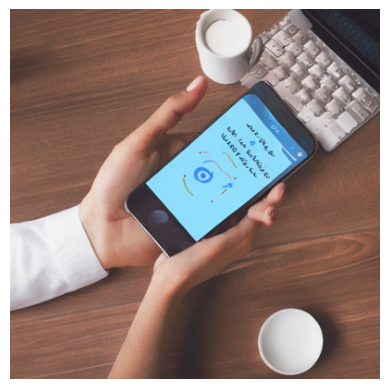

Image saved as generated_image.png


In [ ]:
def main():
    model = load_model()
    prompt = get_user_input()
    generated_image = generate_image(prompt, model)
    display_and_save_image(generated_image)

if __name__ == "__main__":
    main()
